# Handwritten Recognition using Deep Learning Models
In this lab we want to build a **Deep Neural Network** that is able to classify the handwritten digits.

We will use the **Mnist** dataset, and we will build three model, one simple **Convolutional Neural Network**, the second one will be the same as the first one, but we will train the model using the **ImageDataGenerator**, so we will perform an **Augmetation** on the train set, and the third one will be with an **Convolutional** combined with **Long-Short Term Memory (LSTM)**.

---

## Table of Contents

<ol>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Convolutional-Neural-Network">Convolution Neural Network</a>
        <ol>
            <li><a href="#Preprocessing">Preprocessing</a></li>
            <li><a href="#Creating The Model">Creating The Model </a>
            <li><a href="#Fitting The Model">Fitting The Model</a>
            <li><a href="#Test with my Hand Written Digits">Test with my Hand Written Digits</a>    
            </li>
        </ol>
    </li>
    <li><a href="Augmentation">Augmentation</a>
    </li>
    <li><a href="#CNN, No Pooling Layer, Trained with Augmentated Data">CNN, No Pooling Layer, Trained with Augmentated Data</a>
        <ol>
            <li><a href="#Creating The Model">Creating The Model </a>
            <li><a href="#Fitting The Model">Fitting The Model</a>
            <li><a href="#Test with my Hand Written Digits">Test with my Hand Written Digits</a>    
            </li>
        </ol>
    <li><a href="#CNN, With Pooling Layer, Trained With Augmented Data"> CNN, With Pooling Layer, Trained With Augmented Data
</a>
        <ol>
            <li><a href="#Creating The Model">Creating The Model </a>
            <li><a href="#Fitting The Model">Fitting The Model</a>
            <li><a href="#Test with my Hand Written Digits">Test with my Hand Written Digits</a>    
            </li>
        </ol>
    <li><a href="#Combining CNN and LSTM, Trained with Augmented Data">Combining CNN and LSTM, Trained with Augmented Data</a>
        <ol>
            <li><a href="#Creating The Model">Creating The Model </a>
            <li><a href="#Fitting The Model">Fitting The Model</a>
            <li><a href="#Test with my Hand Written Digits">Test with my Hand Written Digits</a>    
            </li>
        </ol>
    <li><a href="Results">Results</a>
    </li>

---

## Setup

### Importing Required Libraries

Let's start importing all the required libraries we're going to use.

In [1]:
import warnings
warnings.simplefilter('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
import matplotlib.pyplot as plt
from tensorflow import keras
#from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, LSTM, Reshape, Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import pandas as pd
from keras.utils import to_categorical
import tensorflow as tf
from PIL import Image, ImageOps
import time
import pprint

import random as rn

### Defining Helper Functions

The following are Helper Function, very useful in order to not re-write same piece of code everytime we needed it.

In [2]:
##this function is to garantee the reproducibility of the models.

def reset_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    rn.seed(seed)
seed = 1234
reset_seeds(seed)

In [3]:
def plot_my_digits(list_digit):
    for i, imgs in enumerate(list_digit):
        bx = plt.subplot(1,10, i+1)
        bx = plt.imshow(imgs, cmap ='gray')
    
        plt.xticks([])
        plt.yticks([])   

In [4]:
def graph_history(history, title='Log Loss and Accuracy over iterations'):

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(title)
    N_plots=len(history.history.keys())
    color_list=['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w','bx','rx']
    for i,(key, items) in enumerate(history.history.items()):
        ax = fig.add_subplot(1, N_plots, i+1)
        ax.plot(items,c=color_list[i])
        ax.grid(True)
        ax.set(xlabel='iterations', xticks=np.arange(0, len(history.history.keys())+2,1),
               title=key, xticklabels=np.arange(1, len(history.history.keys())+3,1))

In [5]:
def score_function(model, x_train, y_train, x_test, y_test, name_of_the_model, time_for_train, n_epochs):
    score_dict = {'Model':[name_of_the_model], 'train_loss':[], 'train_accuracy':[],
                  'test_loss':[], 'test_accuracy':[], 'n_epochs':[n_epochs], 
                  'time_for_train(m)':[round(time_for_train,2)]}
    train_loss, train_accuracy = model.evaluate(x_train, y_train)
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    score_dict['train_loss'].append(round(train_loss,4))
    score_dict['train_accuracy'].append(round(train_accuracy,4))
    score_dict['test_loss'].append(round(test_loss,4))
    score_dict['test_accuracy'].append(round(test_accuracy,4))
    return score_dict

In [6]:
def plot_results(result_df_):
    result_df = result_df_.copy()
    result_df['train_accuracy_plt'] = result_df['train_accuracy']-0.95
    result_df['test_accuracy_plt'] = result_df['test_accuracy']-0.95

    x_labels_raw = result_df.Model
    x_labels = []
    for str_ in x_labels_raw:
        str_new = str_.replace(', ','\n')
        str_new = str_new.replace('no','No')
        str_new = str_new.replace('Augmentation','Aug')
        x_labels.append(str_new)

    fig = plt.figure(figsize=(9,11))
    ax = fig.add_subplot(2,2,1)

    ax = plt.bar(result_df['Model'], result_df['train_accuracy_plt'], width = -0.4, align='edge', color='green', label='Train Accuracy' )
    ax = plt.bar(result_df['Model'], result_df['test_accuracy_plt'], width= 0.4, align='edge', color='blue', label = 'Test Accuracy')
    ax = plt.xticks(ticks=[0,1,2,3], labels=x_labels, fontsize = 8)
    #ax = plt.xlabel(result_df['Model'].items(),rotation=100)
    y_labels_ax = []
    for i in np.arange(0.95,1,0.005):
        y_labels_ax.append(round(i,4))
    ax = plt.yticks(np.arange(0,0.055,0.005), labels=y_labels_ax)
    ax = plt.legend()
    ax = plt.title('Train and Test Accuracy')
    
    
    ax1 = fig.add_subplot(2,2,2)
    ax1 = plt.bar(result_df['Model'], result_df['train_loss'], width=-0.4, align='edge', color='green', label='Train Loss')
    ax1 = plt.bar(result_df['Model'], result_df['test_loss'], width=0.4, align='edge', color ='blue', label= 'Test Loss')
    ax1 = plt.title('Train and Test Loss')
    ax1 = plt.xticks(ticks=[0,1,2,3], labels=x_labels, fontsize = 8)
    ax1 = plt.legend()
    
    
    ax2 = fig.add_subplot(2,2,3)
    ax2 = plt.bar(result_df['Model'], result_df['time_for_train(m)'], width=0.7, color = 'green')
    ax2 = plt.xticks(ticks=[0,1,2,3], labels=x_labels, fontsize = 8)
    ax2 = plt.title('Time Spent For Training')
    ax2 = plt.ylabel('Minutes')
    
    ax3 = fig.add_subplot(2,2,4)
    ax3 = plt.bar(result_df['Model'], result_df['n_epochs'], color = 'blue', width = 0.7)
    ax3 = plt.xticks(ticks=[0,1,2,3], labels=x_labels, fontsize = 8)
    ax3 = plt.ylabel('Number of Epochs')
    ax3 = plt.title('Number of Epochs')
    fig.show()

---

## Convolutional Neural Network

### Preprocessing

Our first model will be a simple **CNN**.

We can procede downloadind the **Minst Dataset**.

In [7]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) =keras.datasets.mnist.load_data()

In [8]:
x_train.shape

(60000, 28, 28)

As we can see our train set is comoposed of 60'000 images of 28x28 pixels.

Let's visualize the first five digits from the training set.

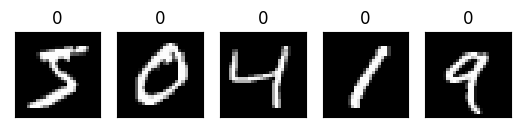

In [9]:
for imgs in range(0,5):
    ax = plt.subplot(1, 5, imgs+1)
    ax = plt.imshow(x_train[imgs], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(np.argmax(y_train[imgs]))

The following codes represent some manipulation data in order to be able to use our 
data in our **Deep Learning Model**.

The first action we take is to scale our data.

In [10]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [11]:
x_train[0].max()

1.0

Here we can see our **y** clasees:

In [12]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [13]:
num_classes = len(np.unique(y_test))
print('Num of Classes:', num_classes)

Num of Classes: 10


We also need to perform a sort of one-hot encoding in order to be able to fit the model with our data.

In [14]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

And a quick look if our **to_categorical** function preserved the right labels.

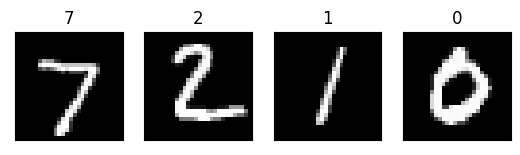

In [15]:
for i in range(0,4):
    ax = plt.subplot(1,4,i+1)
    ax.imshow(x_test[i], cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(np.argmax(y_test[i]))

Perfect!

### Creating the Model
We can now create our **CNN** model.

In [16]:
model_1 = Sequential()

## 4x4 convolution with 2x2 stride and 20 filters
model_1.add(Conv2D(32, (4, 4), strides = (2,2), padding='same', 
                   input_shape = (28,28,1), activation='relu'))

## Another 3x3 convolution with 2x2 stride and 20 filters
model_1.add(Conv2D(32, (3, 3), strides = (2,2), activation='relu'))

## Flatten 
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.3))
#model_1.add(Dense(256, activation='relu'))

#the final layer with softmax activation
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

In [17]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001)

# Let's train the model using RMSprop
model_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [18]:
model_1.build(input_shape=(28,28,1))

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        1184      
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 512)               590336    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
 activation (Activation)     (None, 10)                0

### Fitting the Model
We can now procede to fit our first model:

In [20]:
start=time.time()
history = model_1.fit(x_train, y_train,
              batch_size=32,
              epochs=3, ## NB the number of epochs were found with a couple of trial and error test
                       ##  in order to avoid overfitting
              validation_data=(x_test, y_test),
              shuffle=True)
finish=time.time()
time_spent_1 = (finish-start)/60

Epoch 1/3
1875/1875 [==============================] - 33s 17ms/step - loss: 0.4570 - accuracy: 0.8679 - val_loss: 0.1756 - val_accuracy: 0.9481
Epoch 2/3
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1668 - accuracy: 0.9503 - val_loss: 0.1041 - val_accuracy: 0.9684
Epoch 3/3
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1139 - accuracy: 0.9659 - val_loss: 0.0787 - val_accuracy: 0.9761


Now we can use the 'graph_history' function to plot the training outcome and eventually look for overfitting or other issue.

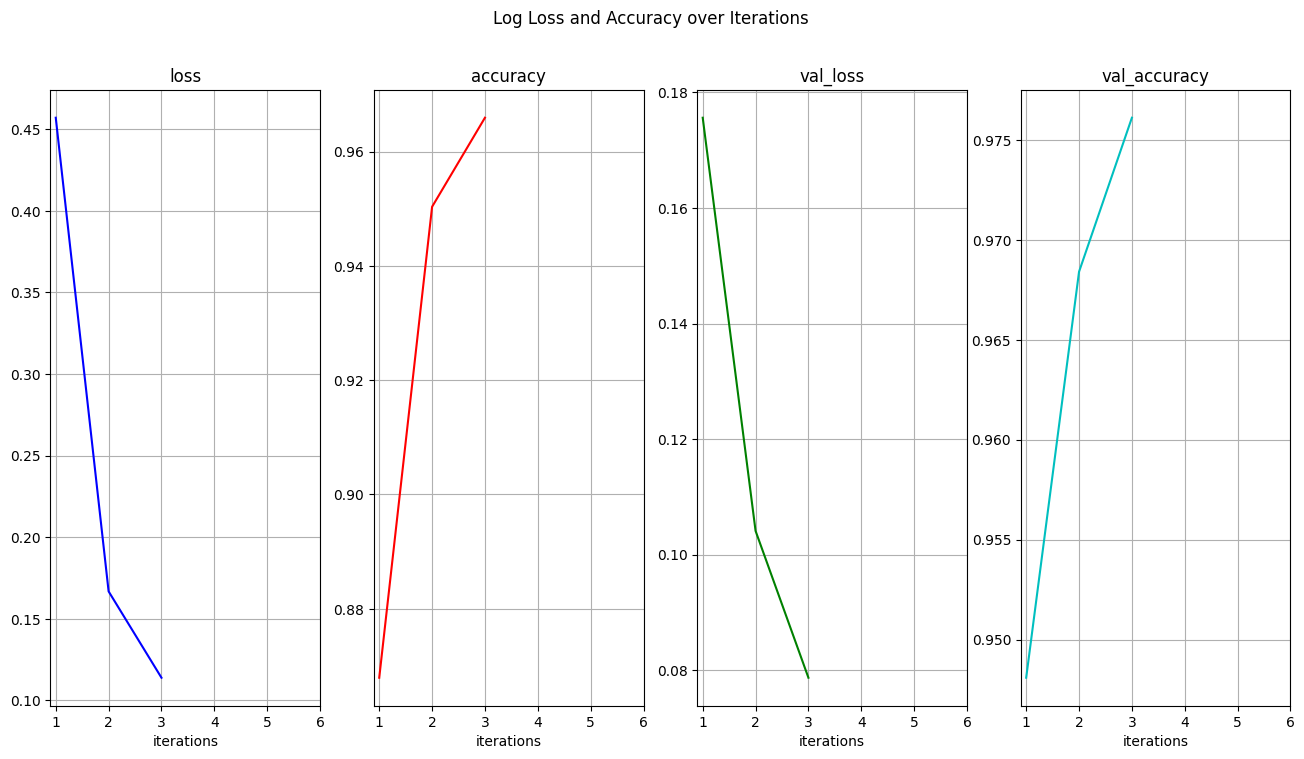

In [21]:
graph_history(history, title='Log Loss and Accuracy over Iterations')

The plots looks fine, we can even fit with an other epoch but then a little bit of overfitting will occurs as already tested out.

In [22]:
score_dict_1 = score_function(model_1, x_train, y_train, x_test, y_test,
                              'Simple CNN, no Pooling, No Augmentation',
                              time_spent_1, 3)

313/313 [==============================] - 2s 5ms/step - loss: 0.0787 - accuracy: 0.9761


In [23]:
pprint.pprint(score_dict_1)

{'Model': ['Simple CNN, no Pooling, No Augmentation'],
 'n_epochs': [3],
 'test_accuracy': [0.9761],
 'test_loss': [0.0787],
 'time_for_train(m)': [1.63],
 'train_accuracy': [0.9762],
 'train_loss': [0.0802]}


### Test with my Hand Written Digits

The model is fitted and seems to have a great accuracy, let's see in a real life situation how well 
it will perform.
I drawn 10 digits, let's if the model is able to predict right!

My hand written digits are saved in the following directory, but they are not ready
to be predicted by our model. We need to modify them, reshaping to 28x28, and converting into a grayscale.

In [24]:
dir_files = 'prove_my_hand_written_digits/'
files = os.listdir(dir_files)

In [25]:
my_hand_wr = []
my_hand_wr_aug = []

## NB the reason of the two different list is that for our model trained without augmentation
## the images needs to be rescaled, while using the DataImageGenerator the rescaling step
## is included in the Generator, so we don't need to rescale before putting them into the model.
for file in files:
    img = Image.open(f'{dir_files}{file}')
    img = img.resize((28,28))
    img = img.convert('L')
    img = ImageOps.invert(img)
    img_arr = np.array(img)
    img_fin = img_arr.astype('float32')/255.
    my_hand_wr.append(img_fin)
    my_hand_wr_aug.append(img_arr)

The scaled ones:


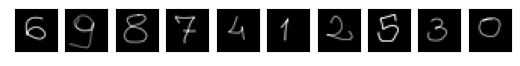

In [26]:
print("The scaled ones:")
plot_my_digits(my_hand_wr)

The non-scaled ones:


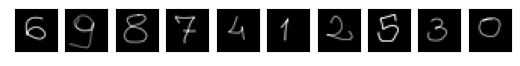

In [27]:
print("The non-scaled ones:")
plot_my_digits(my_hand_wr_aug)

Perfect, we can now see our models performs on this digits:

In [28]:
np.argmax(model_1.predict(np.array(my_hand_wr)), axis=1)

1/1 [==============================] - 0s 129ms/step


array([5, 9, 5, 7, 5, 5, 2, 5, 5, 7])

Despite the accuracy and loss data, our model on our digits performs **Very Bad**. So our next question is easy:
There's anything we can do in order to make our model performs better?

Yes we can try to train our model with using an **Augmentation Technique**. A very powerful tools often used in this kind of problems. 

## **Augmentation**
Perfect, let's build our second model.
Let's re-download our dataset.

In [29]:
(x_train_for_aug, y_train_for_aug), (x_test_for_aug, y_test_for_aug) =keras.datasets.mnist.load_data()

We will use the **flow_from_dataframe** function, but in order to use it we have to save our images in a local directory and also we have to create a DataFrame with the names of this saved images and their target labels. 

In [30]:
## creating the dir where the images will saved
os.makedirs('Hand_For_Aug/Train_Set', exist_ok=True)

In [31]:
train_dict = {'x':[], 'y':[]}
for i,img in enumerate(x_train_for_aug):
    img_to_save = Image.fromarray(x_train_for_aug[i], mode='L')
    img_to_save.save(f'Hand_For_Aug/Train_Set/{i}.png')
    train_dict['x'].append(f'{i}.png')
    train_dict['y'].append(y_train_for_aug[i])

In [32]:
train_df = pd.DataFrame.from_dict(train_dict)

Let's take a quick look at our Dataframe, to see if everything went right.

In [33]:
train_df.head(3)

,x,y
0,0.png,5
1,1.png,0
2,2.png,4


Let's take a look also at the type of stuff into our Dataframe:

In [34]:
train_df.dtypes

x    object
y     uint8
dtype: object

In order to use our train_df in our ImageDataGenerator we need all the columns of type 'string'. So let's convert the 'y' column.

In [35]:
train_df['y'] = train_df['y'].astype('str')

In [36]:
train_df.dtypes

x    object
y    object
dtype: object

Perfect, we can now proced to create our **Augmentation Model**.

Since the orginal Dataframe is already quite great, we will apply just little modification at our images.

In [37]:
datagen_for_model = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.4,
    zoom_range=0.3,
    brightness_range=[0.2,1],
    rescale=1/255. ,
    samplewise_center=False,
    )

train_data_for_model = datagen_for_model.flow_from_dataframe(dataframe=train_df,
                                                            directory='Hand_For_Aug/Train_Set/',
                                                            x_col='x',
                                                            y_col='y',
                                                            color_mode='grayscale',
                                                            class_mode='categorical',
                                                            target_size=(28,28),
                                                            batch_size=32)

Found 60000 validated image filenames belonging to 10 classes.


## CNN, No Pooling Layer, Trained with Augmentated Data

### Creating The Model

Perfect, we correctly set our **Augmentation Model**. We can now create the **CNN Model**.

In [38]:
model_aug = Sequential()
## 6x6 convolution with 2x2 stride and 32 filters
model_aug.add(Conv2D(32, (6, 6), strides = (2,2), padding='same',
                   input_shape = (28,28,1), activation='relu'))
## Another 3x3 convolution with 2x2 stride and 32 filters
model_aug.add(Conv2D(32 ,(3, 3), strides = (2,2), activation='relu',))

## Flatten 
model_aug.add(Flatten())
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.25))
model_aug.add(Dense(256, activation='relu'))
model_aug.add(Dropout(0.25))

model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

In [39]:
opt_aug = keras.optimizers.legacy.RMSprop(learning_rate=0.0005)#, momentum=0.7)
model_aug.compile(loss='categorical_crossentropy',
              optimizer=opt_aug,
              metrics=['accuracy'])

In [40]:
model_aug.build(input_shape=(28,28,1))

Let's see a quick recap of our model:

In [41]:
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        1184      
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               590336    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)              

### Fitting The Model

We can procede to train our Second Model.

In [42]:
start = time.time()
history_aug = model_aug.fit(train_data_for_model,
                            epochs = 3,
                            shuffle=True, 
                            batch_size=32, 
                            validation_data=(x_test,y_test))
finish=time.time()
time_spent_2=(finish-start)/60

Epoch 1/3
1875/1875 [==============================] - 121s 64ms/step - loss: 0.4961 - accuracy: 0.8533 - val_loss: 0.0792 - val_accuracy: 0.9757
Epoch 2/3
1875/1875 [==============================] - 96s 51ms/step - loss: 0.1874 - accuracy: 0.9466 - val_loss: 0.1004 - val_accuracy: 0.9720
Epoch 3/3
1875/1875 [==============================] - 94s 50ms/step - loss: 0.1471 - accuracy: 0.9574 - val_loss: 0.0564 - val_accuracy: 0.9839


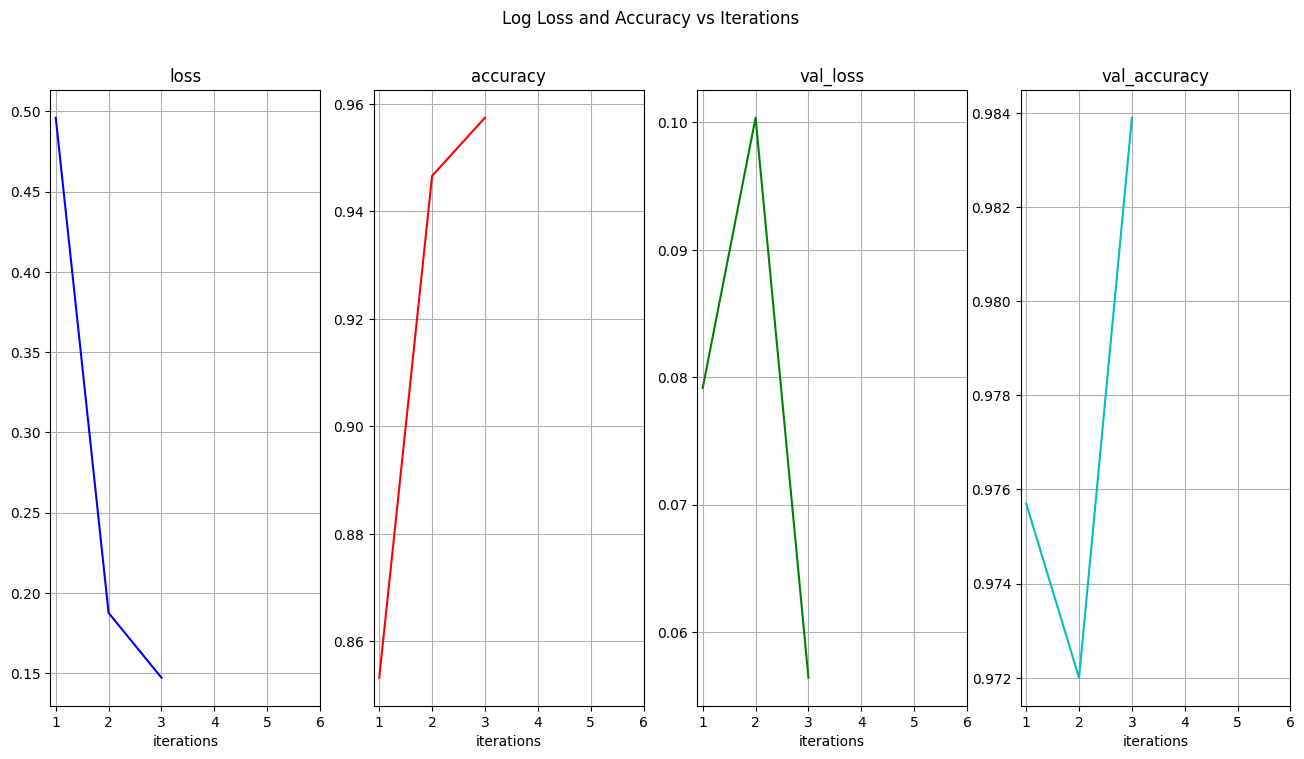

In [43]:
graph_history(history_aug, title='Log Loss and Accuracy vs Iterations')

In [44]:
score_dict_2 = score_function(model_aug, x_train, y_train, x_test, y_test, 
                              'CNN, No Pooling, with Augmentation', 
                              time_spent_2, 3)

313/313 [==============================] - 2s 5ms/step - loss: 0.0564 - accuracy: 0.9839


In [45]:
pprint.pprint(score_dict_2)

{'Model': ['CNN, No Pooling, with Augmentation'],
 'n_epochs': [3],
 'test_accuracy': [0.9839],
 'test_loss': [0.0564],
 'time_for_train(m)': [5.18],
 'train_accuracy': [0.9839],
 'train_loss': [0.0637]}


From the graphs we can see that nothing particularly is changed, just the loss increased a little bit.
Let's see how this model will perform on our digits.

### Test with my Hand Written Digits

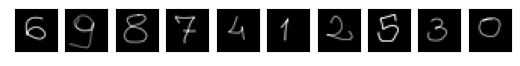

In [46]:
plot_my_digits(my_hand_wr)

In [47]:
np.argmax(model_aug.predict(np.array(my_hand_wr_aug)), axis=1)

1/1 [==============================] - 0s 104ms/step


array([6, 9, 8, 7, 4, 1, 2, 5, 3, 0])

**Perfect!** This time our model was able to predict correctly all my digits.

## CNN, With Pooling Layer, Trained With Augmented Data
Now in this model we cut off the **Pooling Layer**  from the previous model, let's build another model equal to this one but this time we will add even a Pooling Layer in order to see if our model can perform even better.

### Creating the Model

In [48]:
model_aug_pool = Sequential()


## 6x6 convolution with 2x2 stride and 32 filters
model_aug_pool.add(Conv2D(32, (5, 5), strides = (2,2), padding='same', 
                   input_shape = (28,28,1), activation='relu'))
## The Pooling layer
model_aug_pool.add(MaxPooling2D(pool_size=(2, 2)))

## Another 3x3 convolution with 2x2 stride and 32 filters
model_aug_pool.add(Conv2D(32 ,(3, 3), strides = (2,2), activation='relu'))

#model_aug.add(Dropout(0.2))

## Flatten
model_aug_pool.add(Flatten())
model_aug_pool.add(Dense(512, activation='relu' ))
model_aug_pool.add(Dropout(0.2))
model_aug.add(Dense(256, activation='relu'))
#model_aug.add(Dropout(0.25))

## the final layer
model_aug_pool.add(Dense(num_classes))
model_aug_pool.add(Activation('softmax'))

opt_aug_pool = keras.optimizers.legacy.RMSprop(learning_rate=0.0005)#, momentum=0.7)

model_aug_pool.compile(loss='categorical_crossentropy',
              optimizer=opt_aug_pool,
              metrics=['accuracy'])
model_aug_pool.build(input_shape=(28,28,1))

In [49]:
model_aug_pool.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               147968    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

### Fitting The Model

In [50]:
start = time.time()
history_aug_pool = model_aug_pool.fit(train_data_for_model, 
                                      epochs = 3,
                                      shuffle=True, 
                                      batch_size=32, 
                                      validation_data=(x_test,y_test))
finish = time.time()
time_spent_3=(finish-start)/60

Epoch 1/3
1875/1875 [==============================] - 79s 42ms/step - loss: 0.6141 - accuracy: 0.8187 - val_loss: 0.1059 - val_accuracy: 0.9685
Epoch 2/3
1875/1875 [==============================] - 79s 42ms/step - loss: 0.2406 - accuracy: 0.9339 - val_loss: 0.0922 - val_accuracy: 0.9715
Epoch 3/3
1875/1875 [==============================] - 80s 43ms/step - loss: 0.1801 - accuracy: 0.9495 - val_loss: 0.0592 - val_accuracy: 0.9810


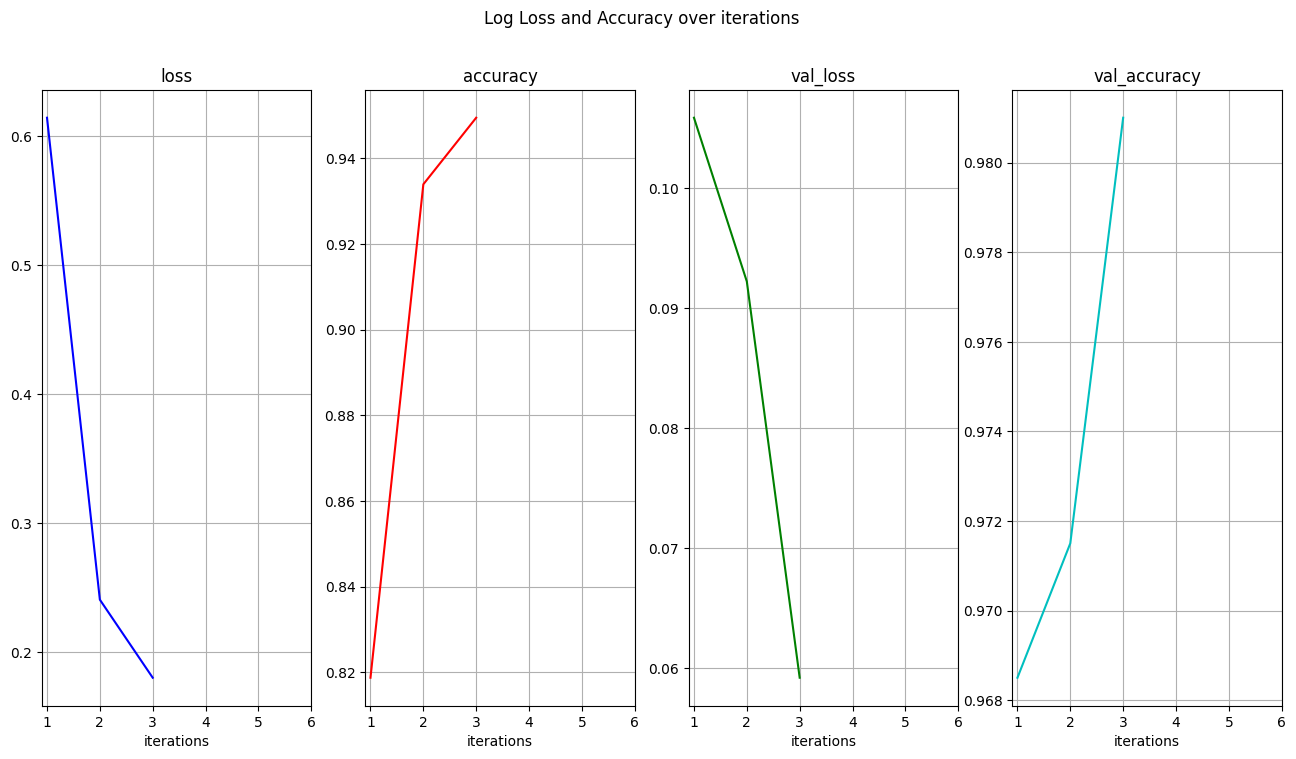

In [51]:
graph_history(history_aug_pool)

In [52]:
score_dict_3 = score_function(model_aug_pool, x_train, y_train, x_test, y_test,
                              'CNN, Pooling, and Augmentation',
                              time_spent_3, 3)

313/313 [==============================] - 1s 4ms/step - loss: 0.0592 - accuracy: 0.9810


In [53]:
pprint.pprint(score_dict_3)

{'Model': ['CNN, Pooling, and Augmentation'],
 'n_epochs': [3],
 'test_accuracy': [0.981],
 'test_loss': [0.0592],
 'time_for_train(m)': [4.02],
 'train_accuracy': [0.9776],
 'train_loss': [0.0793]}


### Test with my Digits

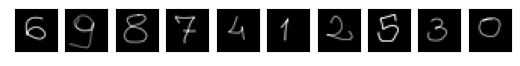

In [54]:
plot_my_digits(my_hand_wr_aug)

In [55]:
np.argmax(model_aug_pool.predict(np.array(my_hand_wr_aug)), axis=1)

1/1 [==============================] - 0s 101ms/step


array([6, 9, 8, 7, 4, 1, 2, 5, 3, 0])

Not too bad, even in this case the model predicted quite well our digits!

## Combining CNN and LSTM, Trained with Augmented Data
Our last model will be a combination of **Convolutional Layer** and a **Long-Short Term Memory Layer**, that sometimes can lead better performance, altough is meant to be used with sequential data like for examples videos, but anyway it's worth to give it a try.

### Creating the Model

In [56]:
def reshape_layer(x):
    
    ## this function is meant to reshape the Conv2D output in a shape that
    ## is suitable for the LSTM
    shape = x.shape
    #reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
    reshape = Reshape((6, 6*32))(x)
    return reshape

model_rnn = Sequential()
model_rnn.add(Conv2D(filters = 32, kernel_size = (5,5),
                     padding='same',
                     strides=(2,2),
                     input_shape = (28,28,1),
                     activation = 'relu'))
model_rnn.add(Conv2D(32, (3,3), activation='relu', strides=(2,2)))
model_rnn.add(Lambda(reshape_layer))
#model_rnn.add(Flatten())
model_rnn.add(LSTM(256, activation = 'relu'))
model_rnn.add(Dropout(0.3))
#model_rnn.add(Dense(256, activation='relu'))
#model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=10, activation='softmax'))

opt_rnn = keras.optimizers.legacy.RMSprop(learning_rate=0.001, momentum=0.5)

model_rnn.compile(loss='categorical_crossentropy', optimizer=opt_aug_pool, metrics=['accuracy'])
model_rnn.build(input_shape=(28,28,1))

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 lambda (Lambda)             (None, 6, 192)            0         
                                                                 
 lstm (LSTM)                 (None, 256)               459776    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                2570      
                                                                 
Total params: 472,426
Trainable params: 472,426
Non-tr

### Fitting The Model

In [57]:
start = time.time()
history_rnn = model_rnn.fit(train_data_for_model,
                            validation_data=(x_test, y_test),
                            batch_size=32, epochs=3, shuffle=True)
finish = time.time()
time_spent_4 = (finish-start)/60

Epoch 1/3
1875/1875 [==============================] - 122s 64ms/step - loss: 0.7610 - accuracy: 0.7552 - val_loss: 0.1430 - val_accuracy: 0.9556
Epoch 2/3
1875/1875 [==============================] - 120s 64ms/step - loss: 0.2439 - accuracy: 0.9279 - val_loss: 0.0938 - val_accuracy: 0.9725
Epoch 3/3
1875/1875 [==============================] - 119s 63ms/step - loss: 0.1782 - accuracy: 0.9501 - val_loss: 0.0674 - val_accuracy: 0.9819


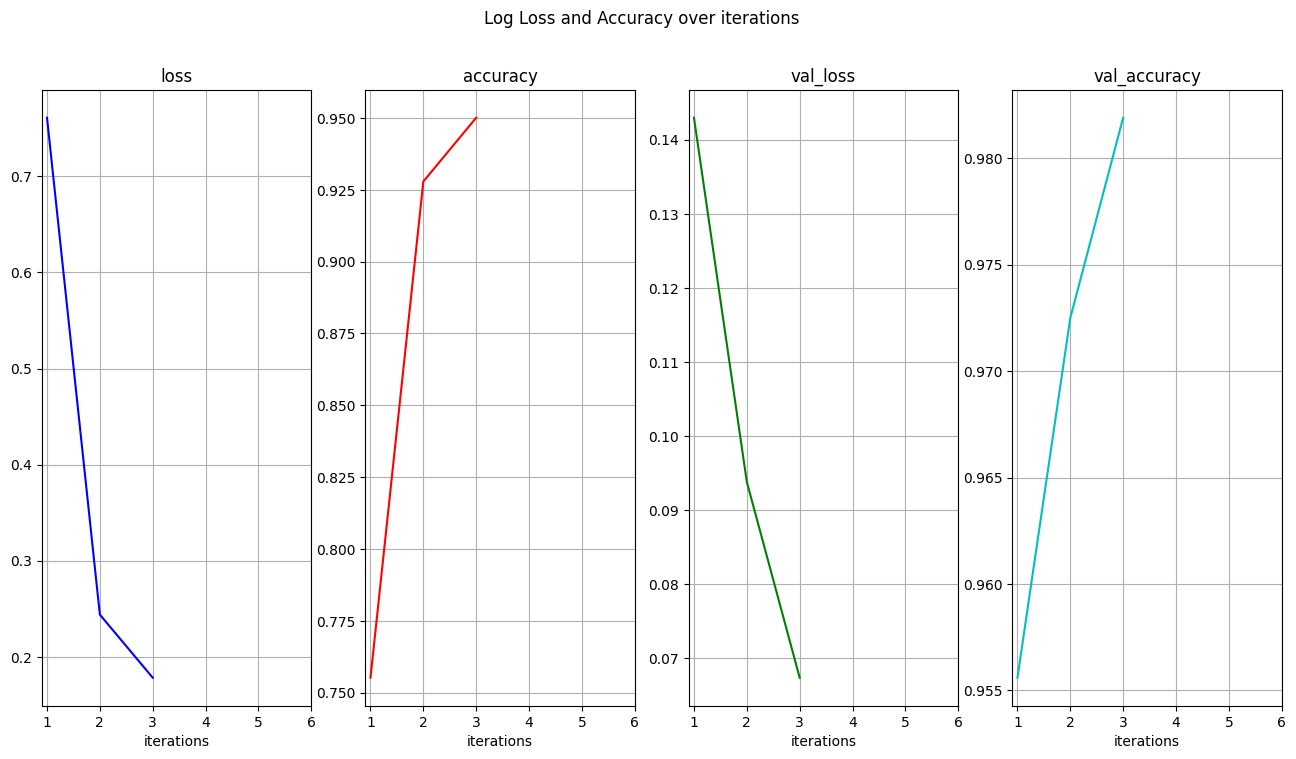

In [58]:
graph_history(history_rnn)

In [59]:
score_dict_4 = score_function(model_rnn, x_train, y_train, x_test, y_test,
                              'CNN, RNN, Augmentation',
                              time_spent_4, 3)

313/313 [==============================] - 3s 11ms/step - loss: 0.0674 - accuracy: 0.9819


In [60]:
pprint.pprint(score_dict_4)

{'Model': ['CNN, RNN, Augmentation'],
 'n_epochs': [3],
 'test_accuracy': [0.9819],
 'test_loss': [0.0674],
 'time_for_train(m)': [6.38],
 'train_accuracy': [0.9798],
 'train_loss': [0.0797]}


### Test With My Hand Written Digits

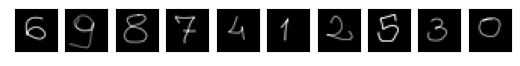

In [61]:
plot_my_digits(my_hand_wr)

In [62]:
np.argmax(model_rnn.predict(np.array(my_hand_wr_aug)), axis =1)

1/1 [==============================] - 0s 265ms/step


array([6, 9, 8, 7, 4, 1, 2, 5, 3, 0])

Great outcome even in this case.

## Results

At this point we can collect all the results metrics ecc in a dataframe. So we
can easly plot them for better understanding.

In [63]:
merged_dict = {}
for key in score_dict_1.keys() | score_dict_2.keys() | score_dict_3.keys() | score_dict_4.keys():
    merged_dict[key] = score_dict_1.get(key)[0], score_dict_2.get(key)[0], score_dict_3.get(key)[0], score_dict_4.get(key)[0]

In [64]:
result_df_ = pd.DataFrame.from_dict(merged_dict)
result_df_.to_csv('Result_Hand_Written', index=False)

In [65]:
result_df_

,time_for_train(m),test_loss,train_accuracy,Model,test_accuracy,n_epochs,train_loss
0,1.63,0.0787,0.9762,"Simple CNN, no Pooling, No Augmentation",0.9761,3,0.0802
1,5.18,0.0564,0.9839,"CNN, No Pooling, with Augmentation",0.9839,3,0.0637
2,4.02,0.0592,0.9776,"CNN, Pooling, and Augmentation",0.9810,3,0.0793
3,6.38,0.0674,0.9798,"CNN, RNN, Augmentation",0.9819,3,0.0797


And finally the plotted results:

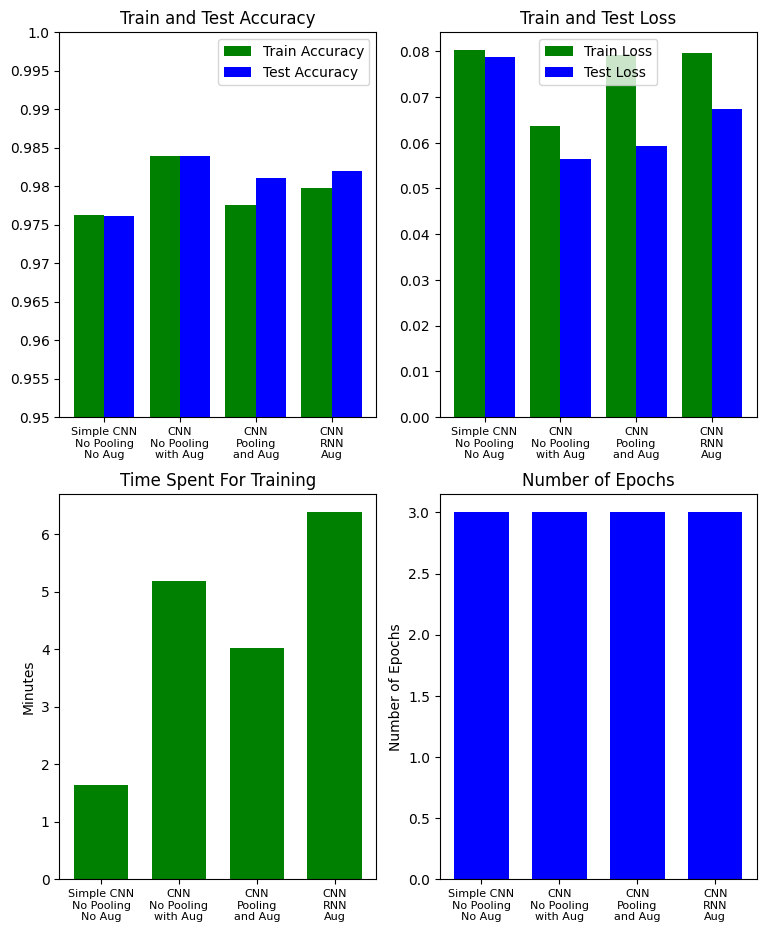

In [67]:
plot_results(result_df_)

As we can see from the plots, the Augmentation performed -even if it was quite moderate- contributed in a better value Accuracy, and in fact the Models Trained with Augmentation not only scored better but they were also able to predict right the real digits. We can also observe that time required for training, for equal number epochs, was consistently higher for the ones trained with Augmentation. And this is quite obviously considering that Augmentation produces on the spot the images to feed the model.

## Author
Giovanni C.

This notebook is available on: 

[SignoG's GitHub](https://github.com/SignorG/Handwritten_Proj/)